# Imports and Data Loading
This cell sets up the environment by importing all the required libraries for machine learning, evaluation, and plotting. It then loads the final analytical dataset that was created during the feature engineering phase.

In [12]:
import pandas as pd
import lightgbm as lgb
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

# --- Configuration ---
DATA_DIR = Path("../output")
MODEL_DATA_FILE = DATA_DIR / "readmissions_dataset.parquet"

# --- Load the Dataset ---
print(f"Loading dataset from {MODEL_DATA_FILE}...")
df = pd.read_parquet(MODEL_DATA_FILE)

print("Dataset loaded successfully.")
df.head()

Loading dataset from ../output/readmissions_dataset.parquet...
Dataset loaded successfully.


,encounter_id,patient_id,readmitted_within_30_days,length_of_stay,age_at_admission,gender,race,marital_status,admission_reason,admission_reason_detail,...,total_claim_cost,income,admission_day_of_week,primary_diagnosis_code,provider_id,payer_dx_interaction,prior_admissions_last_year,num_diagnoses,num_procedures,num_medications
0,ef5d7e9f-956d-2b7a-a4a6-c632f3b40cf9,1f167660-c201-84b9-f69a-16d19d622bfa,1,7,60,male,White,M,Patient transfer to intensive care unit (proce...,History of coronary artery bypass grafting (si...,...,67106.281250,99505,Wednesday,399261000,us-npi|9999868992,Blue Cross Blue Shield_399261000,0,0.0,24.0,0.0
1,3c5e1be2-468a-e4d8-11f2-e767d59482d5,1f167660-c201-84b9-f69a-16d19d622bfa,0,1,60,male,White,M,Admission to ward (procedure),History of coronary artery bypass grafting (si...,...,2176.229980,99505,Wednesday,399261000,us-npi|9999868992,Blue Cross Blue Shield_399261000,1,0.0,4.0,0.0
2,6f06a6aa-a1da-bcd6-a43f-ddbbd638947c,68bfa4c8-e3ac-6dda-a02a-a225c0b2c9a5,0,1,35,female,White,M,Admission to surgical department (procedure),Sterilization requested (situation),...,4495.109863,119210,Saturday,183996000,us-npi|9999952390,NO_INSURANCE_183996000,0,1.0,2.0,0.0
3,e2477992-082b-69ca-3152-6fecf4442626,45ccdf82-db5c-3947-2d97-ee18a8a9c4e3,0,12,53,female,White,W,Hospital admission for isolation (procedure),Disease caused by severe acute respiratory syn...,...,37806.300781,60503,Saturday,840539006,us-npi|9999943399,Anthem_840539006,0,4.0,27.0,0.0
4,735f3287-d205-1ec8-9668-fcdac03f306a,a5a065d0-a35b-d8e3-fda6-0e92c0a40926,0,1,63,female,White,M,Admission to intensive care unit (procedure),Chronic congestive heart failure (disorder),...,4361.350098,49355,Monday,88805009,us-npi|9999868992,Medicare_88805009,0,0.0,5.0,0.0


# Feature Engineering & Preprocessing
Before training, this section prepares the data for the models. It separates the features from the target variable, identifies all the categorical columns, and splits the data into training and testing sets while preserving the original distribution of readmissions.

In [13]:
# Define the target and features
TARGET = 'readmitted_within_30_days'

# Drop identifiers and high-cardinality text fields that might not be useful directly
features_to_drop = ['encounter_id', 'patient_id', 'admission_reason_detail']
X = df.drop(columns=[TARGET] + features_to_drop)
y = df[TARGET]

# Identify categorical features for the models
categorical_features = [
    'gender', 'race', 'marital_status', 'admission_reason', 
    'payer', 'admission_day_of_week', 'primary_diagnosis_code', 
    'provider_id', 'payer_dx_interaction'
]

# Convert categorical features to the 'category' dtype for efficiency
for col in categorical_features:
    X[col] = X[col].astype('category')

print(f"Target variable: {TARGET}")
print(f"Number of features: {len(X.columns)}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Target variable: readmitted_within_30_days
Number of features: 17
Training set shape: (83254, 17)
Test set shape: (20814, 17)


# Train LightGBM Model
Here, we train our first model, LightGBM. This gradient boosting library is known for its speed and efficiency. We fit the model on the training data, telling it which features to treat as categorical, and then use it to make predictions on the unseen test data.

In [14]:
# Initialize the LightGBM classifier
lgbm = lgb.LGBMClassifier(random_state=42)

# Train the model
print("Training LightGBM model...")
lgbm.fit(X_train, y_train, categorical_feature=categorical_features)

# Make predictions
lgbm_preds = lgbm.predict(X_test)
lgbm_preds_proba = lgbm.predict_proba(X_test)[:, 1]

print("✅ LightGBM training complete.")

Training LightGBM model...
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 14827, number of negative: 68427
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2911
[LightGBM] [Info] Number of data points in the train set: 83254, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.178094 -> initscore=-1.529318
[LightGBM] [Info] Start training from score -1.529318
✅ LightGBM training complete.


## LightGBM Model Evaluation
To understand how well the LightGBM model performed, this cell calculates several key evaluation metrics, including accuracy, AUC, precision, and recall. A confusion matrix is also plotted to provide a clear visual of the model's predictive performance.

--- LightGBM Performance ---
Accuracy: 0.9196
AUC Score: 0.9538

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     17107
           1       0.91      0.60      0.73      3707

    accuracy                           0.92     20814
   macro avg       0.92      0.80      0.84     20814
weighted avg       0.92      0.92      0.91     20814

Confusion Matrix:


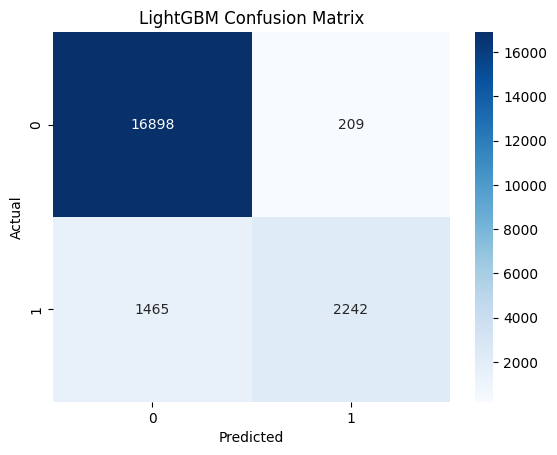

In [15]:
print("--- LightGBM Performance ---")
print(f"Accuracy: {accuracy_score(y_test, lgbm_preds):.4f}")
print(f"AUC Score: {roc_auc_score(y_test, lgbm_preds_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, lgbm_preds))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, lgbm_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('LightGBM Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Train CatBoost Model
Now we train our second model, CatBoost, which is specifically designed to excel with categorical data. After a quick preprocessing step to handle missing values, we fit the model on the training data and generate predictions on the test set.

In [16]:
# --- Add this preprocessing step ---
print("Preprocessing for CatBoost: Filling NaN in categorical features...")
for col in categorical_features:
    X_train[col] = X_train[col].astype(str).fillna('missing')
    X_test[col] = X_test[col].astype(str).fillna('missing')
    
    # Convert back to category dtype after filling
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')
    
print("Preprocessing complete.")

Preprocessing for CatBoost: Filling NaN in categorical features...
Preprocessing complete.


In [17]:
# --- Your original CatBoost code will now work ---
# Initialize the CatBoost classifier
cat = cb.CatBoostClassifier(random_state=42, verbose=0, cat_features=categorical_features)

# Train the model
print("Training CatBoost model...")
cat.fit(X_train, y_train)

# Make predictions
cat_preds = cat.predict(X_test)
cat_preds_proba = cat.predict_proba(X_test)[:, 1]

print("✅ CatBoost training complete.")

Training CatBoost model...
✅ CatBoost training complete.


## CatBoost Model Evaluation
This cell evaluates the CatBoost model using the same metrics as before. We review its accuracy, AUC, precision, and recall, and visualize its performance with a confusion matrix to compare it directly with LightGBM.

--- CatBoost Performance ---
Accuracy: 0.9222
AUC Score: 0.9570

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     17107
           1       0.94      0.60      0.73      3707

    accuracy                           0.92     20814
   macro avg       0.93      0.80      0.84     20814
weighted avg       0.92      0.92      0.92     20814

Confusion Matrix:


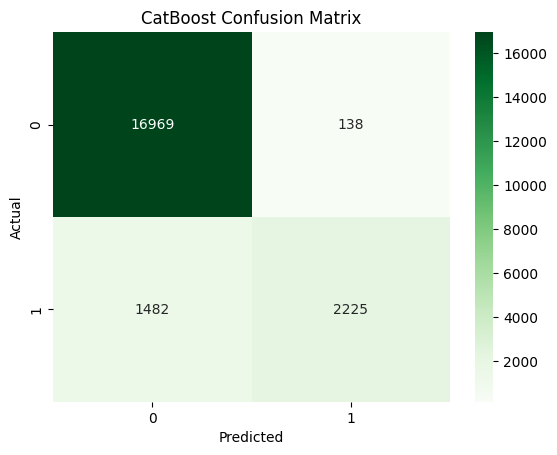

In [18]:
print("--- CatBoost Performance ---")
print(f"Accuracy: {accuracy_score(y_test, cat_preds):.4f}")
print(f"AUC Score: {roc_auc_score(y_test, cat_preds_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, cat_preds))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, cat_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title('CatBoost Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Model Comparison & Feature Importance
This section provides a head-to-head comparison of the two models based on their AUC scores. We then examine the feature importance from the better-performing model (CatBoost) to understand which factors were most influential in predicting readmissions.

In [19]:
print("--- Model Comparison ---")
print(f"LightGBM AUC: {roc_auc_score(y_test, lgbm_preds_proba):.4f}")
print(f"CatBoost AUC: {roc_auc_score(y_test, cat_preds_proba):.4f}")

# Get feature importances from the better model (or both)
# Let's assume CatBoost performed slightly better and use it for importance
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': cat.get_feature_importance()
}).sort_values('importance', ascending=False)

print("\nFeatures by Importance (from CatBoost):")
display(feature_importance_df)

--- Model Comparison ---
LightGBM AUC: 0.9538
CatBoost AUC: 0.9570

Features by Importance (from CatBoost):


,feature,importance
10,primary_diagnosis_code,24.517878
15,num_procedures,22.084662
5,admission_reason,16.036298
11,provider_id,5.568385
1,age_at_admission,5.563000
7,total_claim_cost,5.493817
13,prior_admissions_last_year,4.493833
12,payer_dx_interaction,2.545504
8,income,2.430199
6,payer,2.080557


# Improving Recall
Our initial models have high accuracy but struggle to correctly identify patients who are actually readmitted (low recall). This section explores techniques to address this class imbalance and improve recall, which is often more important in a clinical setting.

## Adjust the Decision Threshold 
The most direct method to improve recall is to adjust the model's decision threshold. By default, a prediction probability of 0.5 is the cutoff for classifying a patient as "readmitted." However, for an imbalanced problem like this one, a model might be uncertain about many true cases, assigning them probabilities below 0.5. By manually lowering this threshold, we can increase the model's sensitivity, capturing more of the true positive cases and thereby boosting recall. This action involves a direct trade-off, as a lower threshold will also increase the number of false positives, which reduces precision. A precision-recall curve is an excellent tool for visualizing this trade-off and selecting an optimal threshold that aligns with the project's clinical or business goals.

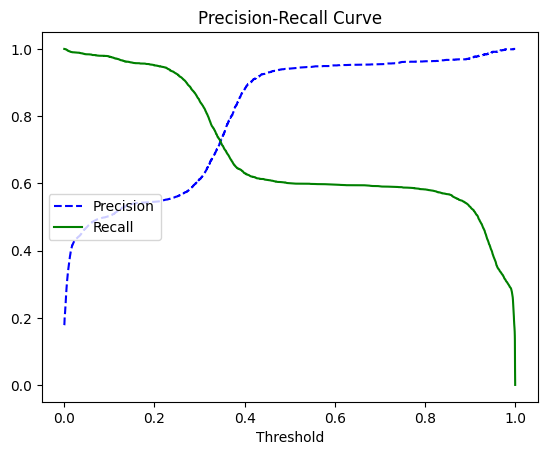

--- Results with new threshold of 0.35 ---
              precision    recall  f1-score   support

           0       0.98      0.84      0.91     17107
           1       0.56      0.93      0.70      3707

    accuracy                           0.86     20814
   macro avg       0.77      0.88      0.80     20814
weighted avg       0.91      0.86      0.87     20814



In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score

# Get prediction probabilities for the positive class
y_probs = cat.predict_proba(X_test)[:, 1]

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Plot the curve
plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
plt.plot(thresholds, recall[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.legend(loc='center left')
plt.title('Precision-Recall Curve')
plt.show()

# Example: Set a new threshold and see the result
new_threshold = 0.25
new_preds = (y_probs >= new_threshold).astype(int)

print("--- Results with new threshold of 0.35 ---")
print(classification_report(y_test, new_preds))

## Class Weighting
Another powerful technique is class weighting, which modifies the model's training process to address the class imbalance directly. Standard models aim to maximize overall accuracy, and with an imbalanced dataset, they can achieve a high score simply by favoring the majority class (patients who are not readmitted). Class weighting counteracts this by applying a heavier penalty to the model whenever it misclassifies an instance of the minority class. By making mistakes on "readmitted" patients more "costly," we force the algorithm to pay closer attention to their patterns, resulting in a model that is inherently better at identifying this smaller, more critical group.

In [21]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate the weight
# count of not readmitted / count of readmitted
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

print(f"Calculated scale_pos_weight: {scale_pos_weight:.2f}")

# Re-initialize and retrain CatBoost with the new parameter
cat_weighted = cb.CatBoostClassifier(
    random_state=42,
    verbose=0,
    cat_features=categorical_features,
    scale_pos_weight=scale_pos_weight  # Add the weight here
)

# Train the model
print("Training weighted CatBoost model...")
cat_weighted.fit(X_train, y_train)

# Evaluate the new model
weighted_preds = cat_weighted.predict(X_test)
print(classification_report(y_test, weighted_preds))

Calculated scale_pos_weight: 4.62
Training weighted CatBoost model...
              precision    recall  f1-score   support

           0       0.99      0.83      0.90     17107
           1       0.55      0.95      0.69      3707

    accuracy                           0.85     20814
   macro avg       0.77      0.89      0.80     20814
weighted avg       0.91      0.85      0.86     20814



## Combining Both
These two techniques are not mutually exclusive and can be powerfully combined for the best overall performance. The process involves two stages. First, we train the model using class weighting, which creates a more recall-aware model from the outset by forcing it to learn the features of the minority class more effectively. Then, as a second step, we analyze the probability scores from this new, weighted model. By plotting a precision-recall curve for these adjusted scores, we can fine-tune the decision threshold to achieve the ideal balance between precision and recall that best suits the specific operational requirements.

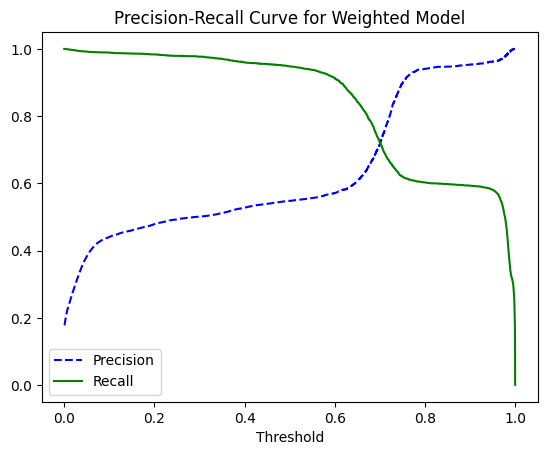

In [22]:
# Use your trained weighted model: cat_weighted
y_probs_weighted = cat_weighted.predict_proba(X_test)[:, 1]

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_probs_weighted)

# Plot the curve to find a good balance
plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
plt.plot(thresholds, recall[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.title('Precision-Recall Curve for Weighted Model')
plt.legend()
plt.show()

--- Final Results with Threshold = 0.7 ---
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     17107
           1       0.72      0.72      0.72      3707

    accuracy                           0.90     20814
   macro avg       0.83      0.83      0.83     20814
weighted avg       0.90      0.90      0.90     20814

Confusion Matrix for Weighted Model:


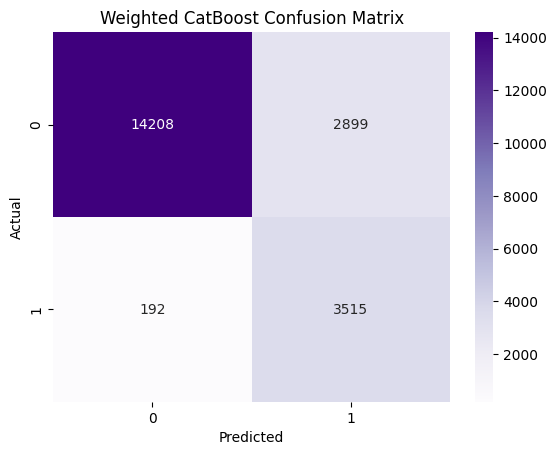

In [23]:
# CHOOSE YOUR THRESHOLD BASED ON THE PLOT
final_threshold = 0.7

# Apply the threshold to the probabilities from your weighted model
final_predictions = (y_probs_weighted >= final_threshold).astype(int)

# Print the final, tuned classification report
print(f"--- Final Results with Threshold = {final_threshold} ---")
print(classification_report(y_test, final_predictions))

print("Confusion Matrix for Weighted Model:")
cm_weighted = confusion_matrix(y_test, weighted_preds)
sns.heatmap(cm_weighted, annot=True, fmt='d', cmap='Purples')
plt.title('Weighted CatBoost Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [24]:
from sklearn.metrics import roc_auc_score

# Use the probabilities from your final weighted model
auc_score = roc_auc_score(y_test, y_probs_weighted)

print(f"Your model's AUC score is: {auc_score:.4f}")

Your model's AUC score is: 0.9560


## Cross Validation
To get a more reliable estimate of our model's performance and ensure it wasn't just lucky on the initial train-test split, we perform 5-fold cross-validation. This process trains and validates the model multiple times on different subsets of the data, providing a more robust and generalizable performance metric.

In [25]:
import numpy as np
import catboost as cb
from sklearn.model_selection import StratifiedKFold

# --- 1. Prepare Your Data ---
# Combine your training and testing sets back into one for cross-validation
# Ensure X has the same preprocessing (NaN filling) as before
X_full = pd.concat([X_train, X_test], ignore_index=True)
y_full = pd.concat([y_train, y_test], ignore_index=True)

# Define categorical features (as a list of column names)
categorical_features = ['gender', 'race', 'marital_status', 'admission_reason', 
                        'payer', 'admission_day_of_week', 'primary_diagnosis_code', 
                        'provider_id', 'payer_dx_interaction']

# --- 2. Set up K-Fold ---
N_SPLITS = 5
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
auc_scores = []

print(f"Starting {N_SPLITS}-Fold Cross-Validation...")

# --- 3. Loop Through Folds ---
for fold, (train_idx, val_idx) in enumerate(skf.split(X_full, y_full)):
    print(f"--- Fold {fold+1}/{N_SPLITS} ---")
    
    # Split data into training and validation sets for this fold
    X_train_fold, X_val_fold = X_full.iloc[train_idx], X_full.iloc[val_idx]
    y_train_fold, y_val_fold = y_full.iloc[train_idx], y_full.iloc[val_idx]

    # Initialize and train your weighted CatBoost model
    # Note: The weight is recalculated for each fold's training data
    scale_pos_weight = (y_train_fold == 0).sum() / (y_train_fold == 1).sum()
    
    model = cb.CatBoostClassifier(
        random_state=42,
        verbose=0,
        cat_features=categorical_features,
        scale_pos_weight=scale_pos_weight
    )
    
    model.fit(X_train_fold, y_train_fold)
    
    # Evaluate on the validation set
    val_probs = model.predict_proba(X_val_fold)[:, 1]
    fold_auc = roc_auc_score(y_val_fold, val_probs)
    auc_scores.append(fold_auc)
    print(f"Fold AUC: {fold_auc:.4f}")

# --- 4. Get Final Results ---
print("\n--- Cross-Validation Complete ---")
print(f"AUC Scores for each fold: {[round(score, 4) for score in auc_scores]}")
print(f"Average AUC Score: {np.mean(auc_scores):.4f}")
print(f"Standard Deviation: {np.std(auc_scores):.4f}")

Starting 5-Fold Cross-Validation...
--- Fold 1/5 ---
Fold AUC: 0.9527
--- Fold 2/5 ---
Fold AUC: 0.9530
--- Fold 3/5 ---
Fold AUC: 0.9521
--- Fold 4/5 ---
Fold AUC: 0.9546
--- Fold 5/5 ---
Fold AUC: 0.9532

--- Cross-Validation Complete ---
AUC Scores for each fold: [0.9527, 0.953, 0.9521, 0.9546, 0.9532]
Average AUC Score: 0.9531
Standard Deviation: 0.0008


# Save the Final Model for Deployment
With our model trained, tuned, and validated, the final step is to save the trained model object to a file. This preserves all the learned parameters and allows us to load the model directly into another application—such as an API—to make predictions on new data without having to retrain it from scratch. We will save the CatBoost model in its native .cbm format to the dedicated models directory.

In [26]:
# --- Define the path for the models directory ---
MODELS_DIR = Path("../models")

# Create the directory if it doesn't exist
MODELS_DIR.mkdir(exist_ok=True)

# --- Define the path for our final model file ---
MODEL_FILE = MODELS_DIR / "catboost_readmissions_model.cbm"

# Save the trained model (using your final weighted model object)
cat_weighted.save_model(MODEL_FILE)

print(f"✅ Model successfully saved to: {MODEL_FILE}")

✅ Model successfully saved to: ../models/catboost_readmissions_model.cbm
